# AI COM2028 COURSEWORK JUPYTER NOTEBOOK

#### Overview <br />
This coursework concerns the automated classification of images through machine learning techniques. You will work on bloodcell image data, where training samples and their
ground truth are provided. You will develop suitable classification techniques to classify
unseen examples, a poster to introduce the problem. You will need to submit a Jupyter
notebook containing your code for training and evaluation, your prediction outcome of the
test dataset, and a poster by 4pm on Wednesday 10th May. Any of your experiment figures
and/or tables included in your poster need to be reproducible in the Jupyter notebook that
you submit.

### Start by importing some relevant modules

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers


# Next load in the training data images <br />
We can do this using skimage.io <br />
We import the imread_collection and concatenate_images functions. <br />
These alllow us to read in the images from a given path, and then the concatenate_images function allows us to convert that collection to a numpy array

<class 'numpy.ndarray'>


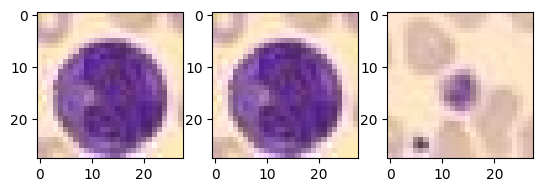

In [15]:
from skimage.io import imread
from skimage.io import imread_collection, concatenate_images

#set file path for local training images
training_images_path = './COM2028_2023/train'

#imread_collection allows us to load folder of images into an array
training_images_collection = imread_collection(training_images_path + '/*.jpg')
training_images = np.concatenate([image[np.newaxis] for image in training_images_collection])
print(type(training_images))

#print out 3 example images from the trianing set in a single row using subplot
plt.subplot(1, 3, 1)
plt.imshow(training_images[1])

plt.subplot(1,3, 2)
plt.imshow(training_images[1])

plt.subplot(1,3,3,)
plt.imshow(training_images[2])
plt.show()

In [16]:
#test image collection
print(len(training_images[0][0]))

28


## Next we need to load in the ground truths labels, these are the truth labels for the training data <br />
### These are loaded in from '/COM2028_2023/train.txt


In [17]:
train_groundtruth_path = './COM2028_2023/train.txt'
training_image_path_list = []

#since we are loading in text (strings) we can use pythons regular file reading functionallity
ground_truths = np.array([])


with open(train_groundtruth_path, 'r') as file:
	for line in file:
		values = line.split(' ') #each line contains path, value seperated by a space
		image_path = values[0]  #path is 1st value [0]
		truth = values[1]  #truth is 2nd value [1]
		truth= truth.strip('\n') #our value has a '\n' appended to it for file formatting, we remove this
		ground_truths = np.append(ground_truths, truth) #we add the value to ground_truths array
		training_image_path_list.append(image_path)

	file.close()

print(ground_truths[0:10])
print(ground_truths.shape)
print(min(ground_truths) + ', ' + max(ground_truths))

['3' '3' '7' '5' '1' '6' '2' '0' '1' '4']
(10000,)
0, 7


# Splitting our training data into training and validation sets <br />
Since our test set is seperate from our training set, we don't need to include this in our training/test split

In [25]:
#Allocate 70% of the training data to training, use the other 30% for validation
sample_count = len(training_images)
print(sample_count)


#convert class vectors  to binary class matrix
ground_truths = keras.utils.to_categorical(ground_truths, 8)
print(training_images.shape)
print(training_images[0].shape)
#split out training data into training and validation set (70/30 split)

training_count = int(sample_count*0.7)
x_train, x_valid = training_images[:training_count], training_images[training_count:]
y_train, y_valid = ground_truths[:training_count], ground_truths[training_count:]





10000
(10000, 28, 28, 3)
(28, 28, 3)


# Ground truth label values range from 0-7



In [19]:
#Manipulate the individual images
image1 = training_images[0]
print(type(image1))
print(image1.shape)



<class 'numpy.ndarray'>
(28, 28, 3)


# Type of classifier to use <br />
Since each target can belong to one of 8 classes, we know we need to use a multiclass classifier for our model. <br /> Binary classifier is not suitable here since that only works for samples that can belong to one of two classes. <br />


# The format of our data
We are analysing images of blood samples. <br />
These images are in the format 28x28x3. That is 28 pixels H by 28 pixels W, each pixel having three color channels for the different RGB color intensities. <br />
## We will need to specify this data format when defining our model <br />
Below is an example of the different RGB color values for one of the training samples <br />


(28, 28, 3)


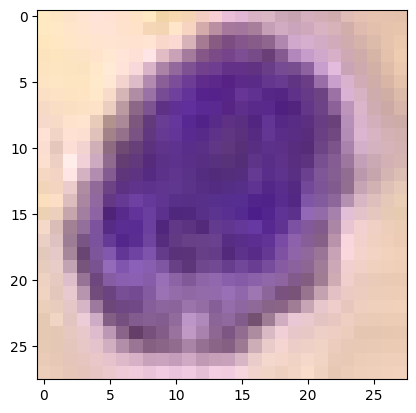

[255 233 195]
[ 86  46 143]


In [20]:
sample1 = training_images[0] #grabs the first training sample
print(sample1.shape)

plt.imshow(sample1)
plt.show()
#get top left pixel values
topleft_pixels = sample1[0][0]
print(topleft_pixels)
#then get ~middle pixe values
middle_pixels = sample1[14][14]
print(middle_pixels)

# Lower color intensity values (~ 0) means closer to the color itself <br />
i.e. In the red color index, a value of 0 means RED, a value of 128 would indiciate ~light red <br />
The above example illustrates this well, with the top left pixel color values all being close to 255 (close to white). <br />
Meanwhile the middle pixels (that result in purple coloring) have RGB values closer to 0 (less white)


# Defining the model <br />
Now that we have gone over the shape of the data, and the relevance of the different pixel intensity values (RGB), we can actually define the model. <br />
As stated before, we want to use a multiclass classification algorithm as each blood sample should belong to one of the 8 classes (0-7). <br /> 
We will define our model using Tensorflow and keras



In [28]:
#Import relevant libraries


#Before defining the model (using keras) we need to define a few hyperparameters for our model
#This includes input shape, hidden layer counts, epoch counts (number of times we want to train the model on our data), 
#, as well the output shape

n_inputs = (28*28*3) #This is the number of 'inputs' per sample that our model will have to analyse
n_hidden1 = 128 #These are the number of neurons in our hidden layer 'n'
n_hidden2 = 64
n_outputs = 8 #This is the number of different classes that our model can take


#Define a multiclass classification model using keras

model1 = keras.Sequential(
    [
        keras.Input(shape = (28*28*3)),
        layers.Dense(n_hidden1, name = 'hidden1', activation = 'relu'),
        layers.Dense(n_hidden2, name ='hidden2', activation = 'relu'),
        layers.Dense(n_outputs, activation = "softmax")
    ]
)

#Print a summyar of our above model
model1.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 128)               301184    
                                                                 
 hidden2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 309,960
Trainable params: 309,960
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Our above model uses softmax as the activation function

#We need to define a cost function for our model
#This is the function our model will use to train our network with our training samples
#We will use CategoricalCrossEntropy for this 1st model.

crossentropy = keras.losses.CategoricalCrossentropy()

#We also need an optimization function for our model. This will be used to tune the hyperparameters
#We will start off using the Adam function
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()




## Now that we have the model and all of the needed parameters defined, we can train the model with our training data <br />

In [30]:
#compile the model with above defined parameters
model1.compile(loss = crossentropy, optimizer = optimizer, metrics = [accuracy])
#Fit our training data to the model. We also pass in the validation data
print(training_images[0].shape)
model1.fit(x_train, y_train, batch_size=128, epochs=10, validation_data = (x_valid, y_valid ), shuffle=True)


(28, 28, 3)
Epoch 1/10


ValueError: in user code:

    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\liam\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 2352), found shape=(None, 28, 28, 3)
